In [ ]:
## submit version
# 1.run warmup block2
# 2. run train block3

./output/tPINN_resNet_FFT_ELU_w=1_layers=[2, 64, 64, 64, 64, 64, 64, 64, 4]/train0.log
Epoch 0: New best model saved with Loss 8295176.0
Epoch 3: New best model saved with Loss 1224358.5
Epoch 6: New best model saved with Loss 251891.9375
Epoch 14: New best model saved with Loss 235517.25
Epoch 17: New best model saved with Loss 222118.140625
Epoch 18: New best model saved with Loss 208561.96875
Epoch 21: New best model saved with Loss 148219.8125
Epoch 22: New best model saved with Loss 131085.484375
Epoch 26: New best model saved with Loss 124828.46875
Epoch 27: New best model saved with Loss 91396.234375
Epoch 32: New best model saved with Loss 74780.75
Epoch 37: New best model saved with Loss 67460.75
Epoch 38: New best model saved with Loss 64699.1796875
Epoch 39: New best model saved with Loss 59710.875
Epoch 40: New best model saved with Loss 55384.734375
Epoch 44: New best model saved with Loss 55030.15625
Epoch 45: New best model saved with Loss 47442.76953125
Epoch 46: New be

ValueError: x and y must have same first dimension, but have shapes (10000,) and (3022,)

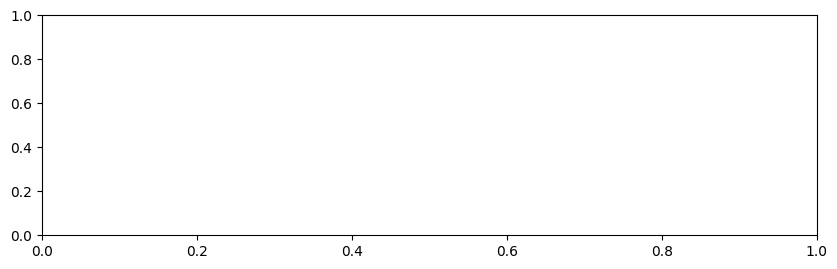

In [2]:
## warmup 阶段用大的学习率先快速下降loss
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import matplotlib.pyplot as plt
import os
import numpy as np
import paddle.optimizer
import logging
import paddle.fft


# 设置模型中的可调参数

layerlist=[2,64,64,64,64,64,64,64,4]
w=1 # boundary condition 的权重
modes=12 # FFT特征保留多少分量
# note='PINN_withhardBC'
note='tPINN_resNet_FFT_ELU'



os.makedirs(output_dir, exist_ok=True)



layerlist_str = ", ".join(map(str, layerlist))
foldername = f"{note}_w={w}_layers=[{layerlist_str}]"

folderpath=os.path.join(output_dir,foldername)
os.makedirs(folderpath, exist_ok=True) 






paralist=[int(file[11:-9]) for file in os.listdir(os.path.join(output_dir,foldername)) if file.startswith('best_model_')]
flag=False
next=0
if len(paralist)>0:
    next=max(paralist)+1
    flag=True

saveparameterfile='best_model_'+str(next)+'.pdparams'
if flag:
    parameterfile='best_model_'+str(next-1)+'.pdparams'
else:
    parameterfile='best_model_0.pdparams'
lossfigname="loss_curve"+str(next)+'.png' 

log_file_path = os.path.join(output_dir, foldername, 'train'+str(next)+'.log')
print(log_file_path)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    filename=log_file_path,       # 日志文件名
    filemode='a',               # 追加模式 (append mode)
    level=logging.INFO,         # 设置日志级别（INFO、DEBUG等）
    format='%(asctime)s %(levelname)s: %(message)s'  # 日志格式
)

class ELU(nn.Layer):
    def forward(self, x):
        mask = 0.5 * (paddle.sign(x) + 1)
        # 限制 exp(x) 的输入范围，避免梯度爆炸
        exp_x = paddle.exp(paddle.clip(x, max=10)) - 1
        return mask * x + (1 - mask) * exp_x
class ResNetBlock(nn.Layer):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = ELU()
        
    def forward(self, x):
        identity = x
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        out += identity  # Residual connection
        out = self.activation(out)
        return out

# 定义神经网络结构，用于逼近解uvpt
class tPINN(nn.Layer):
    def __init__(self, layerlist,modes):
        super(tPINN, self).__init__()
        self.input_layer = nn.Linear(layerlist[0]+modes*2, layerlist[1])
        self.res_blocks = nn.LayerList([
            ResNetBlock(layerlist[i], layerlist[i+1]) for i in range(1,len(layerlist) - 2)
        ])
        self.output_layer = nn.Linear(layerlist[-2], layerlist[-1])
        
    def forward(self, x, y,modes):
        a=1
        # 计算 x 和 y 坐标的 FFT 特征
        x_fft = paddle.real(paddle.fft.fft(x,modes))
        y_fft = paddle.real(paddle.fft.fft(y,modes))
        
        # 将 x, y 和它们的 FFT 特征堆叠
        xy_fft = paddle.concat([x, y, x_fft, y_fft], axis=1)
        
        # 将堆叠的结果作为输入
        out = self.input_layer(xy_fft)
        for res_block in self.res_blocks:
            out = res_block(out)
        result = self.output_layer(out)

        x = xy_fft[:, 0]
        y = xy_fft[:, 1]
        u = result[:, 0]
        v = result[:, 1]
        p = result[:, 2]
        T = result[:, 3]
        
        u = x * (1 - x) * y * (1 - y) * u
        v = x * (1 - x) * y * (1 - y) * v
        T = 1 - x + paddle.sin(paddle.to_tensor(np.pi) * x) * T
        uvpt = paddle.concat([u.unsqueeze(1), v.unsqueeze(1), p.unsqueeze(1), T.unsqueeze(1)], axis=1)
        return uvpt

        
def generate_data(num_points):
    x_data = np.linspace(0, 1, num_points)
    y_data = np.linspace(0, 1, num_points)
    # xy_data_boundary=np.linspace(0, 1, num_boundary_points)


    X, Y = np.meshgrid(x_data, y_data)

    x_train=paddle.to_tensor(X.flatten()[:, None], dtype='float32')
    y_train=paddle.to_tensor(Y.flatten()[:, None], dtype='float32')

    return x_train,y_train
def conv_derivative(u, axis=0, dx=1e-5, verbose=False):
    """ 使用有限差分进行计算"""
    if len(u.shape) != 2:
        raise ValueError("输入张量 u 必须是二维的")
    result=0*u
    if axis==0:
        result[:,1:-1]=(u[:,2:]-u[:,:-2])/(2*dx)
        result[:,0]=(4*u[:,1]-3*u[:,0]-u[:,2])/(2*dx)
        result[:,-1]=(3*u[:,-1]-4*u[:,-2]+u[:,-3])/(2*dx)
    else:
        result[1:-1,:]=(u[2:,:]-u[:-2,:])/(2*dx)
        result[0,:]=(4*u[1,:]-3*u[0,:]-u[2,:])/(2*dx)
        result[-1,:]=(3*u[-1,:]-4*u[-2,:]+u[-3,:])/(2*dx)
    return result


def conv_derivative_2(u, axis=0, dx=1e-5, verbose=False):
    """ 使用有限差分进行计算"""
    if len(u.shape) != 2:
        raise ValueError("输入张量 u 必须是二维的")
    result=0*u
    if axis==0:
        result[:,1:-1]=(u[:,2:]-2*u[:,1:-1]+u[:,:-2])/(dx*dx)
        result[:,0]=(2*u[:,0]-5*u[:,1]+4*u[:,2]-u[:,3])/(dx*dx)
        result[:,-1]=(2*u[:,-1]-5*u[:,-2]+4*u[:,-3]-u[:,-4])/(dx*dx)
    else:
        result[1:-1,:]=(u[2:,:]-2*u[1:-1,:]+u[:-2,:])/(dx*dx)
        result[0,:]=(2*u[0,:]-5*u[1,:]+4*u[2,:]-u[3,:])/(dx*dx)
        result[-1,:]=(2*u[-1,:]-5*u[-2,:]+4*u[-3,:]-u[-4,:])/(dx*dx)
    return result


# 定义微分函数，用于计算 PDE 中的导数
def compute_pde_loss(x,y):
    Pr=0.7
    Ra=1000
    N=num_points+1
    dx=1/(N)

    uvpt = pinn_model(x, y,modes)
    u, v, p, T = uvpt[:, 0:1], uvpt[:, 1:2], uvpt[:, 2:3], uvpt[:, 3:4]
    u=paddle.reshape(u,[N,N])
    v=paddle.reshape(v,[N,N])
    p=paddle.reshape(p,[N,N])
    T=paddle.reshape(T,[N,N])
    
    u_x = conv_derivative(u, axis=0,dx=dx)
    u_y = conv_derivative(u, axis=1,dx=dx)
    v_x = conv_derivative(v, axis=0,dx=dx)
    v_y = conv_derivative(v, axis=1,dx=dx)
    T_x = conv_derivative(T, axis=0,dx=dx)
    T_y = conv_derivative(T, axis=1,dx=dx)
    p_x = conv_derivative(p, axis=0,dx=dx)
    p_y = conv_derivative(p, axis=1,dx=dx)
    
    u_xx = conv_derivative_2(u, axis=0,dx=dx)
    u_yy = conv_derivative_2(u, axis=1,dx=dx)
    v_xx = conv_derivative_2(v, axis=0,dx=dx)
    v_yy = conv_derivative_2(v, axis=1,dx=dx)
    T_xx = conv_derivative_2(T, axis=0,dx=dx)
    T_yy = conv_derivative_2(T, axis=1,dx=dx)
    # 方程
    continuity_residual = (u_x + v_y)[1:-1,1:-1].flatten()
    momentum_u_residual = (u * u_x + v * u_y - Pr * (u_xx + u_yy) + p_x)[1:-1,1:-1].flatten()
    momentum_v_residual = (u * v_x + v * v_y - Pr * (v_xx + v_yy) + p_y -Pr * Ra * T)[1:-1,1:-1].flatten()
    energy_residual = (u * T_x + v * T_y- (T_xx + T_yy))[1:-1,1:-1].flatten()


    left=((p_x-Pr*u_xx)[:,0])**2
    right=((p_x-Pr*u_xx)[:,-1])**2
    PrRaT=Pr * Ra * T
    top=(T_y[-1,:])**2+((p_y-Pr*v_yy-PrRaT)[-1,:])**2
    bottom=(T_y[0,:])**2+((p_y-Pr*v_yy-PrRaT)[0,:])**2

    boundary_residual=paddle.mean(left)+paddle.mean(right)+paddle.mean(top)+paddle.mean(bottom)
    return continuity_residual, momentum_u_residual, momentum_v_residual, energy_residual,boundary_residual



pinn_model = tPINN(layerlist=layerlist,modes=modes)  # 使用新的网络结构
if os.path.exists(os.path.join(output_dir,foldername,parameterfile)):
    pinn_model.set_state_dict(paddle.load(os.path.join(output_dir, foldername,parameterfile)))
    pinn_model.train()

num_points=200
num_boundary_points=4000
x_train,y_train= generate_data(num_points+1)
logging.info(f"{note}")
logging.info(f"num of point {num_points}, layer={layerlist_str},weight of boundary={w}")

# scheduler=paddle.optimizer.lr.CosineAnnealingWarmRestarts(learning_rate=0.005,T_0=50)
# clip=paddle.nn.ClipGradByGlobalNorm(clip_norm=2.0)
optimizer = paddle.optimizer.Adam(parameters=pinn_model.parameters(), learning_rate=0.01)
patience=0
epochs = 10000
losses=[]
best_loss = float('inf')
losses = []
for epoch in range(epochs):
    optimizer.clear_grad()

    # 计算PDE损失
    continuity_residual, momentum_u_residual, momentum_v_residual, energy_residual, boundary_residual = compute_pde_loss(x_train, y_train)
    loss = (
            paddle.mean(continuity_residual**2) +
            paddle.mean(momentum_u_residual**2) +
            paddle.mean(momentum_v_residual**2) +
            paddle.mean(energy_residual**2) +
            boundary_residual * w
        )
    # 反向传播和优化
    loss.backward()
    optimizer.step()

    losses.append([
    paddle.mean(continuity_residual ** 2).numpy(),
    paddle.mean(momentum_u_residual ** 2).numpy(),
    paddle.mean(momentum_v_residual ** 2).numpy(),
    paddle.mean(energy_residual ** 2).numpy(),
    (boundary_residual * w).numpy()])

    
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience=0
        paddle.save(pinn_model.state_dict(), os.path.join(output_dir,foldername, saveparameterfile))
        print(f"Epoch {epoch}: New best model saved with Loss {best_loss}")
        logging.info(f"Epoch {epoch}: New best model saved with Loss {best_loss}")
        logging.info(
            f"Epoch {epoch}: loss {loss.numpy():.6f}, continuity {losses[-1][0]:.6f}, "
            f"momentum_u {losses[-1][1]:.6f}, momentum_v {losses[-1][2]:.6f}, "
            f"energy {losses[-1][3]:.6f}, boundary {losses[-1][4]:.6f}")

    else:
        patience+=1
        logging.info(
            f"Epoch {epoch}: loss {loss.numpy():.6f}, continuity {losses[-1][0]:.6f}, "
            f"momentum_u {losses[-1][1]:.6f}, momentum_v {losses[-1][2]:.6f}, "
            f"energy {losses[-1][3]:.6f}, boundary {losses[-1][4]:.6f}")
    if patience>5000 and loss.numpy()<best_loss*1.1:
        current_lr = optimizer.get_lr()
        optimizer.set_lr(max(current_lr*0.5,1e-6))
        print(f"Learning rate reduced  from {current_lr:.6f} to {current_lr*0.5:.6f}")
        logging.info(f"Learning rate reduced  from {current_lr:.6f} to {current_lr*0.5:.6f}")
        patience=0
    if loss.numpy() >10000*best_loss:
        break

namelist=['continuity','momentum_u','momentum_v','energy','boundary']
fig=plt.figure(figsize=(10,20))
for n in range(5):
    ax=fig.add_subplot(6,1,n+1)
    plt.plot(range(epochs), np.log10(np.array(losses)[:,n]))
    ax.set_ylabel(namelist[n])
ax=fig.add_subplot(6,1,6)
plt.plot(range(epochs), np.log10(np.sum(np.array(losses),axis=1)), label='total')
plt.xlabel('Epochs')
plt.legend()
loss_curve_path = os.path.join(output_dir,foldername, lossfigname)
plt.savefig(loss_curve_path)
plt.close()
logging.info(f"Loss 曲线已保存到 {loss_curve_path}")
logging.shutdown()

In [ ]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import matplotlib.pyplot as plt
import os
import numpy as np
import paddle.optimizer
import logging
import paddle.fft


# 设置模型中的可调参数

layerlist=[2,64,64,64,64,64,64,64,4]
w=1 # boundary condition 的权重
modes=12 # FFT特征保留多少分量
# note='PINN_withhardBC'
note='tPINN_resNet_FFT_ELU'



os.makedirs(output_dir, exist_ok=True)



layerlist_str = ", ".join(map(str, layerlist))
foldername = f"{note}_w={w}_layers=[{layerlist_str}]"

folderpath=os.path.join(output_dir,foldername)
os.makedirs(folderpath, exist_ok=True) 






paralist=[int(file[11:-9]) for file in os.listdir(os.path.join(output_dir,foldername)) if file.startswith('best_model_')]
flag=False
next=0
if len(paralist)>0:
    next=max(paralist)+1
    flag=True

saveparameterfile='best_model_'+str(next)+'.pdparams'
if flag:
    parameterfile='best_model_'+str(next-1)+'.pdparams'
else:
    parameterfile='best_model_0.pdparams'
lossfigname="loss_curve"+str(next)+'.png' 

log_file_path = os.path.join(output_dir, foldername, 'train'+str(next)+'.log')
print(log_file_path)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    filename=log_file_path,       # 日志文件名
    filemode='a',               # 追加模式 (append mode)
    level=logging.INFO,         # 设置日志级别（INFO、DEBUG等）
    format='%(asctime)s %(levelname)s: %(message)s'  # 日志格式
)

class ELU(nn.Layer):
    def forward(self, x):
        mask = 0.5 * (paddle.sign(x) + 1)
        # 限制 exp(x) 的输入范围，避免梯度爆炸
        exp_x = paddle.exp(paddle.clip(x, max=10)) - 1
        return mask * x + (1 - mask) * exp_x
class ResNetBlock(nn.Layer):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = ELU()
        
    def forward(self, x):
        identity = x
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        out += identity  # Residual connection
        out = self.activation(out)
        return out

# 定义神经网络结构，用于逼近解uvpt
class tPINN(nn.Layer):
    def __init__(self, layerlist,modes):
        super(tPINN, self).__init__()
        self.input_layer = nn.Linear(layerlist[0]+modes*2, layerlist[1])
        self.res_blocks = nn.LayerList([
            ResNetBlock(layerlist[i], layerlist[i+1]) for i in range(1,len(layerlist) - 2)
        ])
        self.output_layer = nn.Linear(layerlist[-2], layerlist[-1])
        
    def forward(self, x, y,modes):
        a=1
        # 计算 x 和 y 坐标的 FFT 特征
        x_fft = paddle.real(paddle.fft.fft(x,modes))
        y_fft = paddle.real(paddle.fft.fft(y,modes))
        
        # 将 x, y 和它们的 FFT 特征堆叠
        xy_fft = paddle.concat([x, y, x_fft, y_fft], axis=1)
        
        # 将堆叠的结果作为输入
        out = self.input_layer(xy_fft)
        for res_block in self.res_blocks:
            out = res_block(out)
        result = self.output_layer(out)

        x = xy_fft[:, 0]
        y = xy_fft[:, 1]
        u = result[:, 0]
        v = result[:, 1]
        p = result[:, 2]
        T = result[:, 3]
        
        u = x * (1 - x) * y * (1 - y) * u
        v = x * (1 - x) * y * (1 - y) * v
        T = 1 - x + paddle.sin(paddle.to_tensor(np.pi) * x) * T
        uvpt = paddle.concat([u.unsqueeze(1), v.unsqueeze(1), p.unsqueeze(1), T.unsqueeze(1)], axis=1)
        return uvpt

        
def generate_data(num_points):
    x_data = np.linspace(0, 1, num_points)
    y_data = np.linspace(0, 1, num_points)
    # xy_data_boundary=np.linspace(0, 1, num_boundary_points)


    X, Y = np.meshgrid(x_data, y_data)

    x_train=paddle.to_tensor(X.flatten()[:, None], dtype='float32')
    y_train=paddle.to_tensor(Y.flatten()[:, None], dtype='float32')

    return x_train,y_train
def conv_derivative(u, axis=0, dx=1e-5, verbose=False):
    """ 使用有限差分进行计算"""
    if len(u.shape) != 2:
        raise ValueError("输入张量 u 必须是二维的")
    result=0*u
    if axis==0:
        result[:,1:-1]=(u[:,2:]-u[:,:-2])/(2*dx)
        result[:,0]=(4*u[:,1]-3*u[:,0]-u[:,2])/(2*dx)
        result[:,-1]=(3*u[:,-1]-4*u[:,-2]+u[:,-3])/(2*dx)
    else:
        result[1:-1,:]=(u[2:,:]-u[:-2,:])/(2*dx)
        result[0,:]=(4*u[1,:]-3*u[0,:]-u[2,:])/(2*dx)
        result[-1,:]=(3*u[-1,:]-4*u[-2,:]+u[-3,:])/(2*dx)
    return result


def conv_derivative_2(u, axis=0, dx=1e-5, verbose=False):
    """ 使用有限差分进行计算"""
    if len(u.shape) != 2:
        raise ValueError("输入张量 u 必须是二维的")
    result=0*u
    if axis==0:
        result[:,1:-1]=(u[:,2:]-2*u[:,1:-1]+u[:,:-2])/(dx*dx)
        result[:,0]=(2*u[:,0]-5*u[:,1]+4*u[:,2]-u[:,3])/(dx*dx)
        result[:,-1]=(2*u[:,-1]-5*u[:,-2]+4*u[:,-3]-u[:,-4])/(dx*dx)
    else:
        result[1:-1,:]=(u[2:,:]-2*u[1:-1,:]+u[:-2,:])/(dx*dx)
        result[0,:]=(2*u[0,:]-5*u[1,:]+4*u[2,:]-u[3,:])/(dx*dx)
        result[-1,:]=(2*u[-1,:]-5*u[-2,:]+4*u[-3,:]-u[-4,:])/(dx*dx)
    return result


# 定义微分函数，用于计算 PDE 中的导数
def compute_pde_loss(x,y):
    Pr=0.7
    Ra=1000
    N=num_points+1
    dx=1/(N)

    uvpt = pinn_model(x, y,modes)
    u, v, p, T = uvpt[:, 0:1], uvpt[:, 1:2], uvpt[:, 2:3], uvpt[:, 3:4]
    u=paddle.reshape(u,[N,N])
    v=paddle.reshape(v,[N,N])
    p=paddle.reshape(p,[N,N])
    T=paddle.reshape(T,[N,N])
    
    u_x = conv_derivative(u, axis=0,dx=dx)
    u_y = conv_derivative(u, axis=1,dx=dx)
    v_x = conv_derivative(v, axis=0,dx=dx)
    v_y = conv_derivative(v, axis=1,dx=dx)
    T_x = conv_derivative(T, axis=0,dx=dx)
    T_y = conv_derivative(T, axis=1,dx=dx)
    p_x = conv_derivative(p, axis=0,dx=dx)
    p_y = conv_derivative(p, axis=1,dx=dx)
    
    u_xx = conv_derivative_2(u, axis=0,dx=dx)
    u_yy = conv_derivative_2(u, axis=1,dx=dx)
    v_xx = conv_derivative_2(v, axis=0,dx=dx)
    v_yy = conv_derivative_2(v, axis=1,dx=dx)
    T_xx = conv_derivative_2(T, axis=0,dx=dx)
    T_yy = conv_derivative_2(T, axis=1,dx=dx)
    # 方程
    continuity_residual = (u_x + v_y)[1:-1,1:-1].flatten()
    momentum_u_residual = (u * u_x + v * u_y - Pr * (u_xx + u_yy) + p_x)[1:-1,1:-1].flatten()
    momentum_v_residual = (u * v_x + v * v_y - Pr * (v_xx + v_yy) + p_y -Pr * Ra * T)[1:-1,1:-1].flatten()
    energy_residual = (u * T_x + v * T_y- (T_xx + T_yy))[1:-1,1:-1].flatten()


    left=((p_x-Pr*u_xx)[:,0])**2
    right=((p_x-Pr*u_xx)[:,-1])**2
    PrRaT=Pr * Ra * T
    top=(T_y[-1,:])**2+((p_y-Pr*v_yy-PrRaT)[-1,:])**2
    bottom=(T_y[0,:])**2+((p_y-Pr*v_yy-PrRaT)[0,:])**2

    boundary_residual=paddle.mean(left)+paddle.mean(right)+paddle.mean(top)+paddle.mean(bottom)
    return continuity_residual, momentum_u_residual, momentum_v_residual, energy_residual,boundary_residual



pinn_model = tPINN(layerlist=layerlist,modes=modes)  # 使用新的网络结构
if os.path.exists(os.path.join(output_dir,foldername,parameterfile)):
    pinn_model.set_state_dict(paddle.load(os.path.join(output_dir, foldername,parameterfile)))
    pinn_model.train()

num_points=200
num_boundary_points=4000
x_train,y_train= generate_data(num_points+1)
logging.info(f"{note}")
logging.info(f"num of point {num_points}, layer={layerlist_str},weight of boundary={w}")

# scheduler=paddle.optimizer.lr.CosineAnnealingWarmRestarts(learning_rate=0.005,T_0=50)
# clip=paddle.nn.ClipGradByGlobalNorm(clip_norm=2.0)
optimizer = paddle.optimizer.Adam(parameters=pinn_model.parameters(), learning_rate=1e-5)
patience=0
epochs = 1000000
losses=[]
best_loss = float('inf')
losses = []
for epoch in range(epochs):
    optimizer.clear_grad()

    # 计算PDE损失
    continuity_residual, momentum_u_residual, momentum_v_residual, energy_residual, boundary_residual = compute_pde_loss(x_train, y_train)
    loss = (
            paddle.mean(continuity_residual**2) +
            paddle.mean(momentum_u_residual**2) +
            paddle.mean(momentum_v_residual**2) +
            paddle.mean(energy_residual**2) +
            boundary_residual * w
        )
    # 反向传播和优化
    loss.backward()
    optimizer.step()

    losses.append([
    paddle.mean(continuity_residual ** 2).numpy(),
    paddle.mean(momentum_u_residual ** 2).numpy(),
    paddle.mean(momentum_v_residual ** 2).numpy(),
    paddle.mean(energy_residual ** 2).numpy(),
    (boundary_residual * w).numpy()])

    
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience=0
        paddle.save(pinn_model.state_dict(), os.path.join(output_dir,foldername, saveparameterfile))
        print(f"Epoch {epoch}: New best model saved with Loss {best_loss}")
        logging.info(f"Epoch {epoch}: New best model saved with Loss {best_loss}")
        logging.info(
            f"Epoch {epoch}: loss {loss.numpy():.6f}, continuity {losses[-1][0]:.6f}, "
            f"momentum_u {losses[-1][1]:.6f}, momentum_v {losses[-1][2]:.6f}, "
            f"energy {losses[-1][3]:.6f}, boundary {losses[-1][4]:.6f}")

    else:
        patience+=1
        logging.info(
            f"Epoch {epoch}: loss {loss.numpy():.6f}, continuity {losses[-1][0]:.6f}, "
            f"momentum_u {losses[-1][1]:.6f}, momentum_v {losses[-1][2]:.6f}, "
            f"energy {losses[-1][3]:.6f}, boundary {losses[-1][4]:.6f}")
    if patience>5000 and loss.numpy()<best_loss*1.1:
        current_lr = optimizer.get_lr()
        optimizer.set_lr(max(current_lr*0.5,1e-6))
        print(f"Learning rate reduced  from {current_lr:.6f} to {max(current_lr*0.5,1e-6):.6f}")
        logging.info(f"Learning rate reduced  from {current_lr:.6f} to {max(current_lr*0.5,1e-6):.6f}")
        patience=0


namelist=['continuity','momentum_u','momentum_v','energy','boundary']
fig=plt.figure(figsize=(10,20))
for n in range(5):
    ax=fig.add_subplot(6,1,n+1)
    plt.plot(range(epochs), np.log10(np.array(losses)[:,n]))
    ax.set_ylabel(namelist[n])
ax=fig.add_subplot(6,1,6)
plt.plot(range(epochs), np.log10(np.sum(np.array(losses),axis=1)), label='total')
plt.xlabel('Epochs')
plt.legend()
loss_curve_path = os.path.join(output_dir,foldername, lossfigname)
plt.savefig(loss_curve_path)
plt.close()
logging.info(f"Loss 曲线已保存到 {loss_curve_path}")
logging.shutdown()

./output/tPINN_resNet_FFT_ELU_w=1_layers=[2, 64, 64, 64, 64, 64, 64, 64, 4]/train2.log
Epoch 0: New best model saved with Loss 0.10313453525304794
Epoch 80: New best model saved with Loss 0.10312477499246597
Epoch 96: New best model saved with Loss 0.10309676080942154
Epoch 112: New best model saved with Loss 0.10294969379901886
Epoch 136: New best model saved with Loss 0.10294699668884277
Epoch 169: New best model saved with Loss 0.10287412256002426
Learning rate reduced  from 0.000010 to 0.000005
Epoch 5201: New best model saved with Loss 0.10273648798465729
Epoch 5219: New best model saved with Loss 0.10268910974264145
Epoch 5271: New best model saved with Loss 0.10267330706119537
Epoch 5280: New best model saved with Loss 0.10248980671167374
